# Notebook for Cellpy batch processing

In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import cellpy
from cellpy import prms
from cellpy import prmreader
from cellpy.utils import batch
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
######################################################################
##                                                                  ##
##                       development                                ##
##                                                                  ##
######################################################################

from pathlib import Path
from pprint import pprint

# Use these when working on my work PC:
test_data_path = r"C:\Scripting\MyFiles\development_cellpy\testdata"
out_data_path = r"C:\Scripting\Processing\Test\out"

# Use these when working on my MacBook:
test_data_path = "/Users/jepe/scripting/cellpy/testdata"
out_data_path = "/Users/jepe/cellpy_data"

test_data_path = Path(test_data_path)
out_data_path = Path(out_data_path)

print(" SETTING SOME PRMS ".center(80, "="))
prms.Paths["db_filename"] = "cellpy_db.xlsx"
prms.Paths["cellpydatadir"] = test_data_path / "hdf5"
prms.Paths["outdatadir"] = out_data_path
prms.Paths["rawdatadir"] = test_data_path / "data"
prms.Paths["db_path"] = test_data_path / "db"
prms.Paths["filelogdir"] = test_data_path / "log"
pprint(prms.Paths)

============================== SETTING SOME PRMS ===============================
{'cellpydatadir': PosixPath('/Users/jepe/scripting/cellpy/testdata/hdf5'),
 'db_filename': 'cellpy_db.xlsx',
 'db_path': PosixPath('/Users/jepe/scripting/cellpy/testdata/db'),
 'filelogdir': PosixPath('/Users/jepe/scripting/cellpy/testdata/log'),
 'outdatadir': PosixPath('/Users/jepe/cellpy_data'),
 'rawdatadir': PosixPath('/Users/jepe/scripting/cellpy/testdata/data')}


In [4]:
# prmreader.info()

In [5]:
project = "prebens_experiment"
name = "test"
batch_col = "b01"

print(" INITIALISATION OF BATCH ".center(80, "="))
b = batch.init(name, project, batch_col=batch_col)
print(b)

=========================== INITIALISATION OF BATCH ============================
[CyclingExperiment]
journal: 
(LabJournal)
  - name: test
  - project: prebens_experiment
  - file_name: None
  - pages: ->
None
           <-

data: 
{}



In [48]:
# setting some prms
b.experiment.export_raw = True
b.experiment.export_cycles = True
b.experiment.export_ica = True
b.experiment.all_in_memory = True  # store all data in memory, defaults to False

In [49]:
b.create_info_df()

(cellpy) - name: test
(cellpy) - project: prebens_experiment
(cellpy) - Saved file to /Users/jepe/cellpy_data/prebens_experiment/cellpy_batch_test.json


In [50]:
b.create_folder_structure()

(cellpy) - created folders


In [51]:
b.load_and_save_raw()

(cellpy) - [update experiment]
[|.]
(cellpy) - Processing 20160805_test001_45_cc
(cellpy) - created CellpyData instance
(cellpy) - setting cycle mode (nan)...
(cellpy) - loading cell
(cellpy) - started loadcell
(cellpy) - checking file ids - using 'size'
(cellpy) - cellpy file(s) needs updating - loading raw
(cellpy) - ...loaded successfully...
(cellpy) - Trying to get summary_data
(cellpy) - saving to cellpy-format
(cellpy) - exporting [raw] [cycles]
(cellpy) - /Users/jepe/cellpy_data/prebens_experiment/test/raw_data/20160805_test001_45_cc_01_normal.csv OK
(cellpy) - /Users/jepe/cellpy_data/prebens_experiment/test/raw_data/20160805_test001_45_cc_01_steps.csv OK
(cellpy) - /Users/jepe/cellpy_data/prebens_experiment/test/raw_data/20160805_test001_45_cc_01_stats.csv OK
(cellpy) - /Users/jepe/cellpy_data/prebens_experiment/test/raw_data/20160805_test001_45_cc_01_cycles.csv exported.
(cellpy) - exporting [ica]
(cellpy) - /Users/jepe/miniconda3/envs/cellpy/lib/python3.6/site-packages/scipy/

In [52]:
b.make_summaries()
print("---FINISHED---")

(cellpy) - dumping to csv
(cellpy) - > /Users/jepe/cellpy_data/prebens_experiment/test/summary_discharge_capacity_test.csv
(cellpy) - > /Users/jepe/cellpy_data/prebens_experiment/test/summary_charge_capacity_test.csv
(cellpy) - > /Users/jepe/cellpy_data/prebens_experiment/test/summary_coulombic_efficiency_test.csv
(cellpy) - > /Users/jepe/cellpy_data/prebens_experiment/test/summary_cumulated_coulombic_efficiency_test.csv
(cellpy) - > /Users/jepe/cellpy_data/prebens_experiment/test/summary_ir_discharge_test.csv
(cellpy) - > /Users/jepe/cellpy_data/prebens_experiment/test/summary_ir_charge_test.csv
(cellpy) - > /Users/jepe/cellpy_data/prebens_experiment/test/summary_end_voltage_discharge_test.csv
(cellpy) - > /Users/jepe/cellpy_data/prebens_experiment/test/summary_end_voltage_charge_test.csv
(cellpy) - cycles_engine:
(cellpy) - Not ready for production
(cellpy) - dumping to csv
---FINISHED---


In [53]:
b.plot_summaries()

Loading BokehJS ...

(filled:charge) (open:discharge)


In [54]:
b.experiment.status()



==================================== STATUS ====================================
[CyclingExperiment]
journal: 
(LabJournal)
  - name: test
  - project: prebens_experiment
  - file_name: /Users/jepe/cellpy_data/prebens_experiment/cellpy_batch_test.json
  - pages: ->
                          masses  total_masses  loadings  fixed      labels  \
filenames                                                                     
20160805_test001_45_cc  0.510262        2.8175  0.956369   True  test001_45   
20160805_test001_47_cc  0.495843        2.6975  0.915636  False  test001_47   

                       cell_type  \
filenames                          
20160805_test001_45_cc       nan   
20160805_test001_47_cc       nan   

                                                           raw_file_names  \
filenames                                                                   
20160805_test001_45_cc  [/Users/jepe/scripting/cellpy/testdata/data/20...   
20160805_test001_47_cc  [/Users/jepe/sc

In [55]:
b.summaries.head()

discharge_capacity                         \
            20160805_test001_45_cc 20160805_test001_47_cc   
Cycle_Index                                                 
1                      3439.590727            3539.615176   
2                      3071.900594            3161.232490   
3                      3107.658353            3198.030097   
4                      2973.603806            3060.077199   
5                      2883.195758            2967.040054   

                   charge_capacity                         \
            20160805_test001_45_cc 20160805_test001_47_cc   
Cycle_Index                                                 
1                      3185.432177            3278.065610   
2                      3330.764692            3427.624443   
3                      3393.368073            3492.048351   
4                      3088.563614            3178.380077   
5                      3008.850934            3096.349325   

              coulombic_efficiency                         \
            20160805_test001_45_cc 20160805_test001_47_cc   
Cycle_Index                                                 
1                       107.978778             107.978778   
2                        92.228088              92.228088   
3                        91.580350              91.580350   
4                        96.277888              96.277888   
5                        95.823815              95.823815   

            cumulated_coulombic_efficiency                         \
                    20160805_test001_45_cc 20160805_test001_47_cc   
Cycle_Index                                                         
1                               107.978778             107.978778   
2                               200.206866             200.206866   
3                               291.787216             291.787216   
4                               388.065103             388.065103   
5                               483.888918             483.888918   

                      ir_discharge                         \
            20160805_test001_45_cc 20160805_test001_47_cc   
Cycle_Index                                                 
1                        56.486603              56.486603   
2                        14.831962              14.831962   
3                        14.545353              14.545353   
4                        14.229149              14.229149   
5                        12.762250              12.762250   

                         ir_charge                         \
            20160805_test001_45_cc 20160805_test001_47_cc   
Cycle_Index                                                 
1                        48.372887              48.372887   
2                        43.793484              43.793484   
3                        35.437023              35.437023   
4                        39.807651              39.807651   
5                        43.704582              43.704582   

             end_voltage_discharge                         \
            20160805_test001_45_cc 20160805_test001_47_cc   
Cycle_Index                                                 
1                         0.049894               0.049894   
2                         0.049894               0.049894   
3                         0.049894               0.049894   
4                         0.049894               0.049894   
5                         0.049894               0.049894   

                end_voltage_charge                         
            20160805_test001_45_cc 20160805_test001_47_cc  
Cycle_Index                                                
1                         1.000113               1.000113  
2                         1.000113               1.000113  
3                         1.000113               1.000113  
4                         1.000113               1.000113  
5                         1.000113               1.000113

## Looking more in-depth

### OCV relaxation points
Picking out 5 points on each OCV relaxation curve (distributed by last, last/2, last/2/2, ..., first).

(cellpy) - Analyzing 20160805_test001_45_cc
(cellpy) - Analyzing 20160805_test001_47_cc
   cycle  point_00  point_01  point_02  point_03  point_04  step       type
1      1  0.095465  0.084842  0.088229  0.092232  0.095465     5  ocvrlx_up
3      2  0.096081  0.085150  0.089615  0.093002  0.096081     5  ocvrlx_up
5      3  0.096389  0.086689  0.089769  0.093618  0.096389     5  ocvrlx_up
7      4  0.117019  0.099314  0.104241  0.110399  0.117019    12  ocvrlx_up
9      5  0.122561  0.103317  0.109629  0.116403  0.122561    12  ocvrlx_up


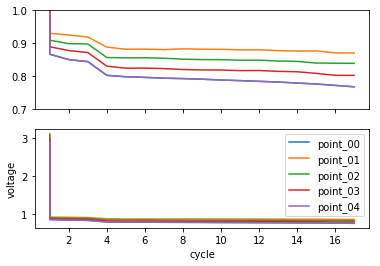

In [56]:
from cellpy.utils.batch_tools.batch_analyzers import OCVRelaxationAnalyzer

analyzer = OCVRelaxationAnalyzer()
analyzer.assign(b.experiment)
analyzer.do()
ocv_df_list = analyzer.farms[0]
df = ocv_df_list[0]
df_up = df.loc[df.type == "ocvrlx_up", :]
df_down = df.loc[df.type == "ocvrlx_down", :]

print(df_up.head())
df_down = df_down.set_index("cycle")

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
df_down.loc[:, ["point_00", "point_01", "point_02", "point_03", "point_04"]].plot(ax=ax1, legend=None)
df_down.loc[:, ["point_00", "point_01", "point_02", "point_03", "point_04"]].plot(ax=ax2)
ax1.set_ylim(0.7,1)
ax2.set_ylabel("voltage");

## Looking closer at some summary-plots

In [57]:
b.summary_columns

Index(['discharge_capacity', 'discharge_capacity', 'charge_capacity',
       'charge_capacity', 'coulombic_efficiency', 'coulombic_efficiency',
       'cumulated_coulombic_efficiency', 'cumulated_coulombic_efficiency',
       'ir_discharge', 'ir_discharge', 'ir_charge', 'ir_charge',
       'end_voltage_discharge', 'end_voltage_discharge', 'end_voltage_charge',
       'end_voltage_charge'],
      dtype='object')

In [58]:
discharge_capacity = b.summaries.discharge_capacity
charge_capacity = b.summaries.charge_capacity
coulombic_efficiency = b.summaries.coulombic_efficiency
ir_charge = b.summaries.ir_charge

Text(0,0.5,'resistance')

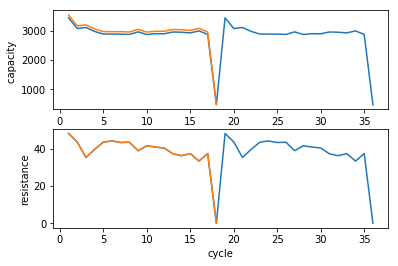

In [59]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(discharge_capacity)
ax1.set_ylabel("capacity ")
ax2.plot(ir_charge)
ax2.set_xlabel("cycle")
ax2.set_ylabel("resistance")

## Checking for more details for each cycle

#### 1. pick the CellpyData object for one of the cells

In [139]:
# Lets check what cells we have
cell_labels = b.experiment.cell_names
cell_labels

['20160805_test001_45_cc', '20160805_test001_47_cc']

In [140]:
# OK, then I choose one of them
data = b.experiment.data["20160805_test001_45_cc"]

#### 2. Get some voltage curves for some cycles and plot them
The method `get_cap` can be used to extract voltage curves.

In [66]:
cap = data.get_cap(categorical_column=True)
cap.head()

,voltage,capacity,direction
0,0.110245,0.000006,-1
1,0.115479,0.546367,-1
2,0.120714,2.793660,-1
3,0.125948,6.325420,-1
4,0.131183,10.348162,-1


Text(0,0.5,'voltage')

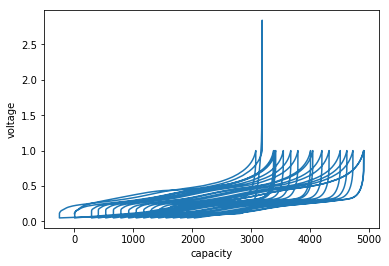

In [71]:
fig, ax = plt.subplots()
ax.plot(cap.capacity, cap.voltage)
ax.set_xlabel("capacity")
ax.set_ylabel("voltage")

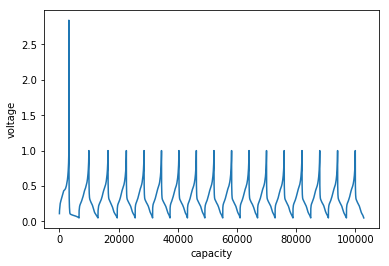

In [83]:
c,v = data.get_cap(method="forth")
fig, ax = plt.subplots()
ax.set_xlabel("capacity")
ax.set_ylabel("voltage")
ax.plot(c,v)

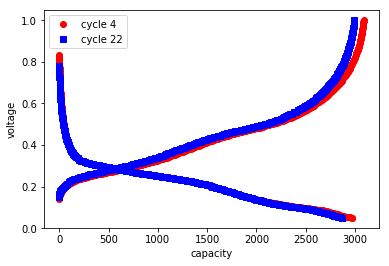

In [97]:
c4,v4 = data.get_cap(cycle=4, method="forth-and-forth")
c10,v10 = data.get_cap(cycle=10, method="forth-and-forth")
fig, ax = plt.subplots()
ax.set_xlabel("capacity")
ax.set_ylabel("voltage")
ax.plot(c4,v4, "ro", label="cycle 4")
ax.plot(c10,v10, "bs", label="cycle 22")
ax.legend();

### Looking at some dqdv data

#### Get capacity cycles and make dqdv using the ica module

(cellpy) - /Users/jepe/miniconda3/envs/cellpy/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]



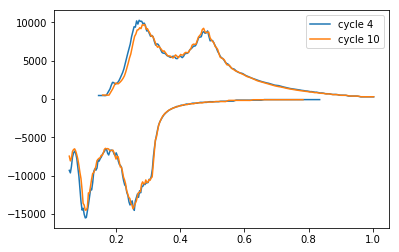

In [135]:
from cellpy.utils import ica
v4, dqdv4 = ica.dqdv_cycle(
    data.get_cap(
        4, 
        categorical_column=True, 
        method = "forth-and-forth")
)

v10, dqdv10 = ica.dqdv_cycle(
    data.get_cap(
        10, 
        categorical_column=True, 
        method = "forth-and-forth")
)

plt.plot(v4,dqdv4, label="cycle 4")
plt.plot(v10, dqdv10, label="cycle 10")
plt.legend();

#### Put it in a for-loop for plotting many ica plots

(cellpy) - /Users/jepe/miniconda3/envs/cellpy/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]

cycle 18 seems to be missing or corrupted
cycle 36 seems to be missing or corrupted


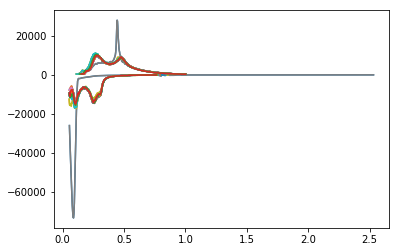

In [134]:
fig, ax = plt.subplots()
for cycle in data.get_cycle_numbers():
    d = data.get_cap(
            cycle, 
            categorical_column=True, 
            method = "forth-and-forth"
        )
    if not d.empty:
        v, dqdv = ica.dqdv_cycle(d)
        ax.plot(v, dqdv)
    else:
        print(f"cycle {cycle} seems to be missing or corrupted")
    